# Kings County Analysis

In [1]:
#Import Necessary Libraries and Data
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.feature_selection import RFECV,SelectKBest, f_regression, mutual_info_regression
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

In [2]:
kings_county_df = pd.read_csv("data/kc_house_data_train.csv", index_col='Unnamed: 0')
kings_county_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


Check descriptive stats and info about each column

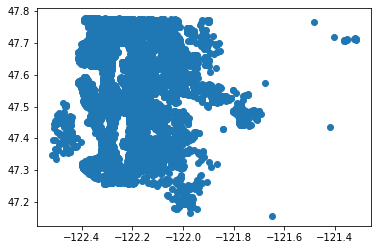

In [3]:
plt.scatter( kings_county_df['long'], kings_county_df['lat'])

In [4]:
#Import Libraries and Data
kings_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

#### Data Cleaning

- Convert date to DateTime Object
- Took count of ID, if id appeared more than once, sold more than once.
- Drop Unnamed Column and ID: Seems irrelevant
- Drop long/lat, I don't think i can think of any good combination that isn't explained by zip code
- Convert zipcode to string

In [5]:
# Convert date to DateTime Object


kings_county_df['date'] = pd.to_datetime(kings_county_df['date'].str.slice(0,8),format="%Y-%m-%d")
# Took count of ID, if id appeared more than once, sold more than once.
dictNumTimesSold = dict(kings_county_df.groupby('id').id.count().sort_values())
kings_county_df['num_times_sold'] = kings_county_df['id'].map(dictNumTimesSold)
# Drop ID: Seems irrelevant
# Drop Long, Lat: Couldn't think of combinations that wouldn't be explained
    # by zipcode
kings_county_df.drop(labels =['id', 'lat', 'long'], axis=1, inplace=True)
# Convert zipcode to string
kings_county_df['zipcode'] = kings_county_df['zipcode'].apply(str)

View extreme numbers and address accordingly. <br><br>Saw a bedroom of 33 and it looks like a typo so set it to 3 bedrooms. Saw 0 bedrooms/0 bathrooms, but may be the test data will have them so I'm leaving them accordingly.

In [6]:
kings_county_df.query("bedrooms == 33")

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,num_times_sold
8597,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,1330,4700,1


In [7]:
kings_county_df.at[8597,'bedrooms'] = 3

In [8]:
kings_county_df.bedrooms.value_counts()

3     7865
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

In [9]:
kings_county_df.bathrooms.value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

Check for NAs

In [10]:
kings_county_df.isna().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view              0
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
sqft_living15     0
sqft_lot15        0
num_times_sold    0
dtype: int64

In [11]:
kings_county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            17290 non-null  datetime64[ns]
 1   price           17290 non-null  float64       
 2   bedrooms        17290 non-null  int64         
 3   bathrooms       17290 non-null  float64       
 4   sqft_living     17290 non-null  int64         
 5   sqft_lot        17290 non-null  int64         
 6   floors          17290 non-null  float64       
 7   waterfront      17290 non-null  int64         
 8   view            17290 non-null  int64         
 9   condition       17290 non-null  int64         
 10  grade           17290 non-null  int64         
 11  sqft_above      17290 non-null  int64         
 12  sqft_basement   17290 non-null  int64         
 13  yr_built        17290 non-null  int64         
 14  yr_renovated    17290 non-null  int64         
 15  zi

#### Early Data Analysis

View the range for number of bedrooms 

<AxesSubplot:>

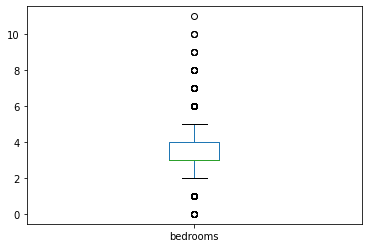

In [12]:
kings_county_df.bedrooms.plot(kind='box')

View the range for number of bathrooms. Mean around 2

<AxesSubplot:>

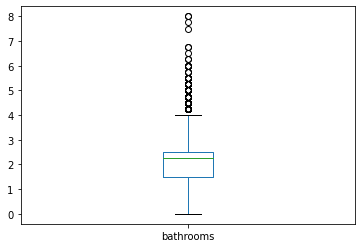

In [13]:
kings_county_df.bathrooms.plot(kind='box')

View average price by bedrooms.

In [14]:
kings_county_df.groupby('bedrooms').price.mean()

bedrooms
0     4.319667e+05
1     3.265255e+05
2     4.006608e+05
3     4.654965e+05
4     6.377381e+05
5     7.847411e+05
6     8.377285e+05
7     9.861672e+05
8     1.255600e+06
9     8.167998e+05
10    8.193333e+05
11    5.200000e+05
Name: price, dtype: float64

View number of bedrooms and handle outliers

<AxesSubplot:>

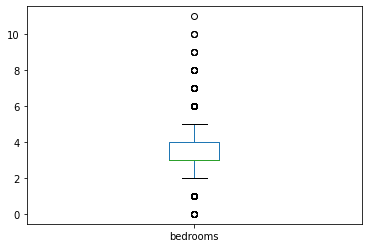

In [15]:
kings_county_df.bedrooms.plot(kind='box')

In [16]:
kings_county_df.bedrooms.value_counts().sort_index()

0       12
1      160
2     2204
3     7865
4     5488
5     1283
6      229
7       30
8       10
9        5
10       3
11       1
Name: bedrooms, dtype: int64

Cap the outliers to a certain number

In [17]:
kings_county_df['bedrooms'] = np.where(kings_county_df['bedrooms'] >= 7, 7, kings_county_df['bedrooms'])


In [18]:
kings_county_df.bedrooms.value_counts().sort_index()

0      12
1     160
2    2204
3    7865
4    5488
5    1283
6     229
7      49
Name: bedrooms, dtype: int64

View range for bathrooms

<AxesSubplot:>

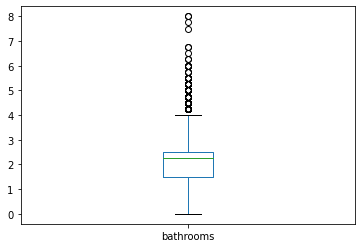

In [19]:
kings_county_df.bathrooms.plot(kind='box')

View count of each bathroom

In [20]:
kings_county_df.bathrooms.value_counts().sort_index()

0.00       8
0.50       3
0.75      52
1.00    3100
1.25       6
1.50    1168
1.75    2431
2.00    1549
2.25    1666
2.50    4322
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      17
5.25      11
5.50       7
5.75       3
6.00       6
6.25       2
6.50       1
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

View bathrooms grouped by mean

In [21]:
kings_county_df.groupby('bathrooms').price.mean()

bathrooms
0.00    5.077062e+05
0.50    2.255000e+05
0.75    2.766520e+05
1.00    3.463276e+05
1.25    6.010000e+05
1.50    4.073672e+05
1.75    4.582803e+05
2.00    4.557473e+05
2.25    5.372734e+05
2.50    5.566379e+05
2.75    6.545027e+05
3.00    7.149029e+05
3.25    9.656770e+05
3.50    9.289996e+05
3.75    1.198263e+06
4.00    1.309828e+06
4.25    1.532047e+06
4.50    1.328587e+06
4.75    1.817828e+06
5.00    1.749518e+06
5.25    1.866118e+06
5.50    2.803286e+06
5.75    3.143333e+06
6.00    2.946833e+06
6.25    3.094000e+06
6.50    2.238890e+06
6.75    2.734000e+06
7.50    4.500000e+05
7.75    6.885000e+06
8.00    4.990000e+06
Name: price, dtype: float64

Cap the bathrooms to a certain number, 7 in this case.

In [22]:
kings_county_df['bathrooms'] = np.where(((kings_county_df['bathrooms']>0)&(kings_county_df['bathrooms']<1)), 1, kings_county_df['bathrooms'])
kings_county_df['bathrooms'] = np.where(kings_county_df['bathrooms']>=5.75, 7, kings_county_df['bathrooms'])
kings_county_df.bathrooms.value_counts().sort_index()



0.00       8
1.00    3155
1.25       6
1.50    1168
1.75    2431
2.00    1549
2.25    1666
2.50    4322
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      17
5.25      11
5.50       7
7.00      18
Name: bathrooms, dtype: int64

In [23]:
kings_county_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'num_times_sold'],
      dtype='object')

See updated descriptive stats

In [24]:
kings_county_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.368826,2.113302,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,1987.986698,12873.475824,1.013187
std,3.733190e+05,0.901955,0.771853,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,684.802635,27227.437583,0.114077
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,399.000000,659.000000,1.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,1490.000000,5111.250000,1.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,1840.000000,7622.500000,1.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,2360.000000,10101.750000,1.000000
max,7.700000e+06,7.000000,7.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,6210.000000,858132.000000,2.000000


In [25]:
continuous = ['price',  'sqft_living', 'sqft_lot',
         'sqft_above', 'sqft_basement',   
       'sqft_living15','view', 'sqft_lot15']

categorical = ['waterfront','condition','grade',
               'bedrooms', 'bathrooms','floors','zipcode']

See the relationship between the continuous variables and the target variable price

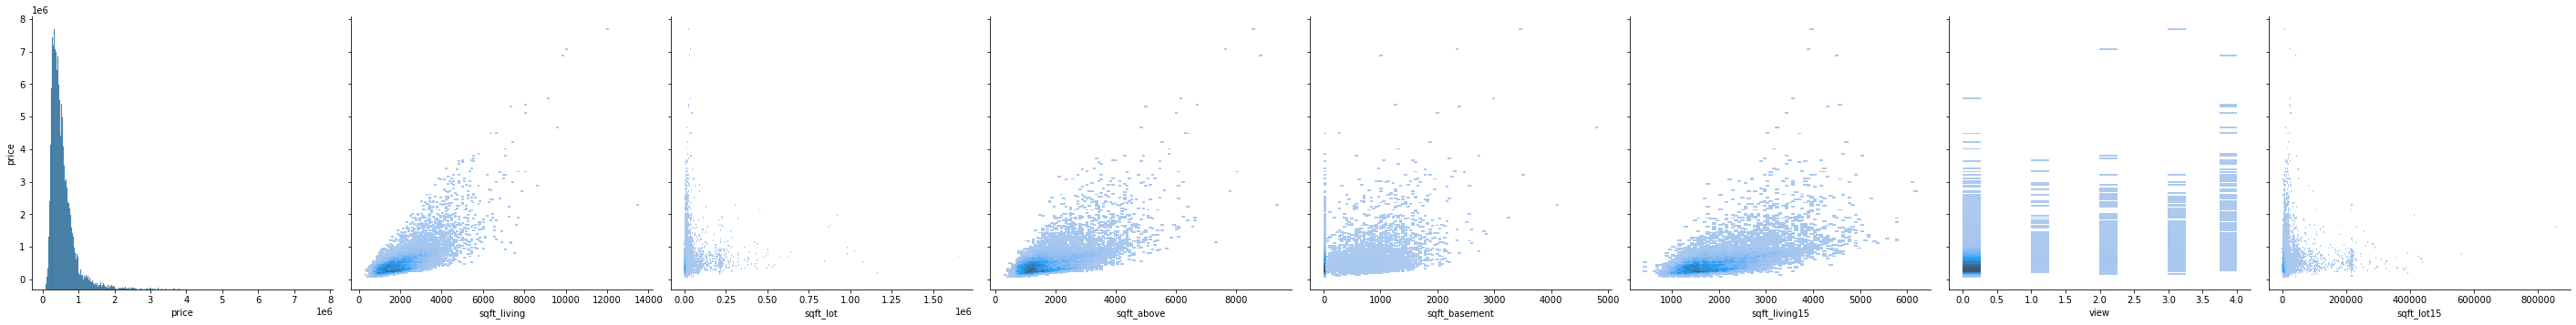

In [26]:
sns.pairplot(data = kings_county_df, y_vars="price", x_vars=continuous, height=5, kind='hist')



View categorical variables against target variable price

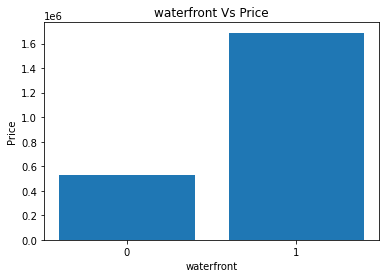

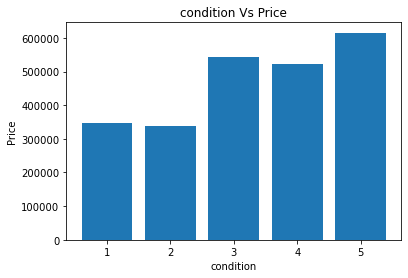

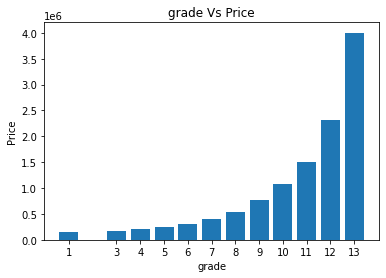

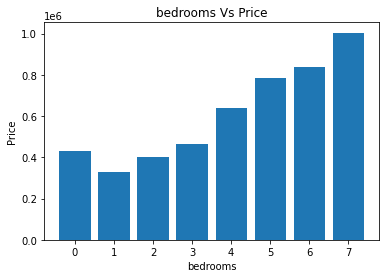

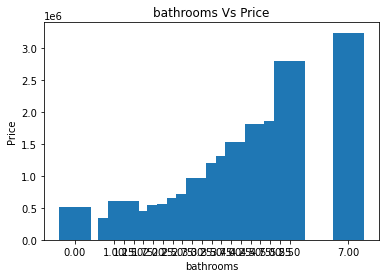

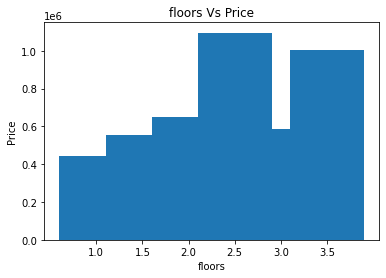

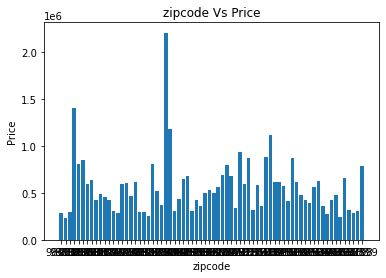

In [27]:
for x in categorical:
    group = kings_county_df.groupby(x).price.mean()
    plt.figure()
    plt.bar(group.index,group.values)
    plt.title(f'{x} Vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)
    plt.xticks(group.index)
    # Show/save figure as desired.
    plt.show()

Categorize grade so it is more linear

In [28]:
conditions = [(kings_county_df['grade'] <= 8),
              (kings_county_df['grade'] <= 12),
             (kings_county_df['grade'] <= 13)]
choices = ['low','medium','high']
kings_county_df['grade_cat'] = np.select(conditions, choices)

H0: Average price of all bedrooms are the same<br>
H1: Average price of all bedrooms are different.

In [29]:
#alpha=.05
samples = kings_county_df.groupby('bedrooms')['price'].apply(list)
stats.f_oneway(*samples)
#Pvalue is lower than alpha so we can reject null hypothesis and say
    #that the average price of all bedrooms are different

F_onewayResult(statistic=290.92340468218185, pvalue=0.0)

View average price by zipcode

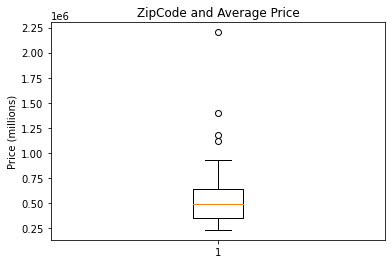

In [30]:
groupedZip = kings_county_df.groupby('zipcode')['price'].mean()

fig, ax = plt.subplots()
ax.boxplot(groupedZip)
ax.set_title('ZipCode and Average Price')
ax.set_ylabel('Price (millions)');

In [31]:
outlier_zips = list((kings_county_df.groupby('zipcode').price.mean().sort_values(ascending=False)).index)[:4]
outlier_zips = ['zipcode_' + sub for sub in outlier_zips]
outlier_zips

['zipcode_98039', 'zipcode_98004', 'zipcode_98040', 'zipcode_98112']

Visualize average price by zipcode

H0: Average price is the same across zipcodes<br>
H1: Average price isn't the same across zipcodes

In [32]:
#alpha = .05
samples = kings_county_df.groupby('zipcode')['price'].apply(list)
stats.f_oneway(*samples)
#Pvalue lower than alpha, reject null hypothesis. 

F_onewayResult(statistic=167.38619664118102, pvalue=0.0)

<BarContainer object of 70 artists>

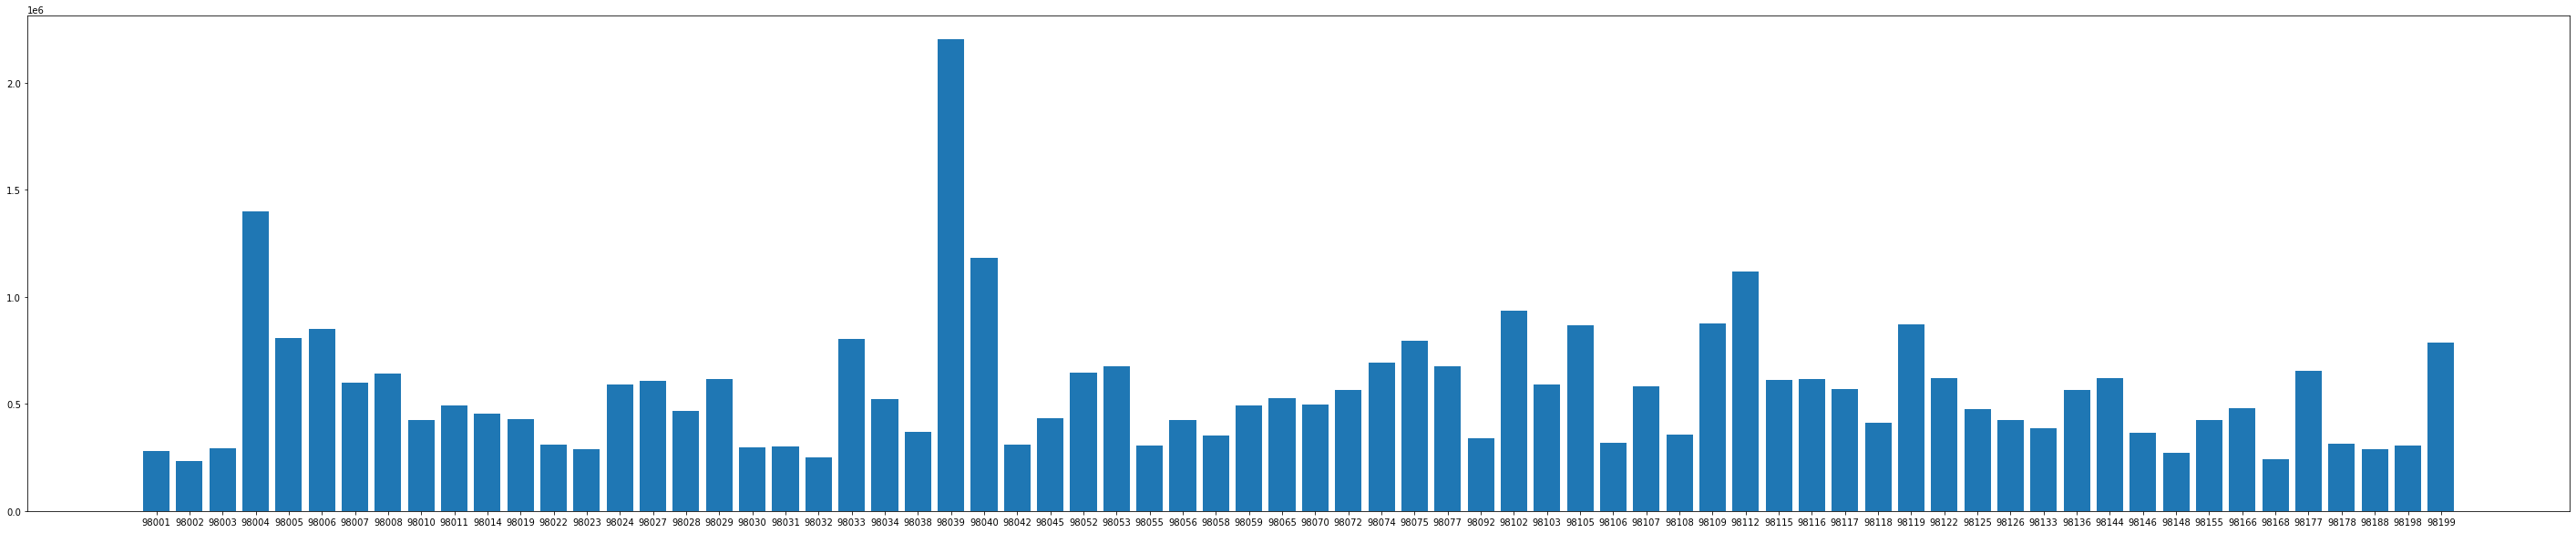

In [33]:
groupedZip = kings_county_df.groupby('zipcode')['price'].mean()

fig, ax = plt.subplots(figsize=(50,10))
ax.bar(x = groupedZip.index,
        height = groupedZip.values)


H0: Average price is the same whether a house has or doesn't have a waterfront<br>
H1: Average price isn't the same whether a house has or doesn't have a waterfront

In [34]:
kings_county_df.waterfront.value_counts()

0    17152
1      138
Name: waterfront, dtype: int64

In [35]:
#alpha = .05

stats.ttest_ind(kings_county_df.query("waterfront == True")['price'], kings_county_df.query("waterfront == False")['price'])

#Pvalue lower than alpha, reject null hypothesis

Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

Check for any correlation

In [36]:
kings_county_df.corr()>.9
#Find any correlated values with a coefficient higher than .9

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [37]:
categorical = ['condition','grade_cat','bedrooms', 'bathrooms','floors','zipcode']


Create dummy variables for categoricals

In [38]:
kc_DF_wDUMS = pd.get_dummies(kings_county_df, columns=categorical, drop_first=True)
kc_DF_wDUMS.head()

,date,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_7.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,0,0,8,2070,0,1986,0,2390,7700,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,0,8,1830,1070,1977,0,2370,6283,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,2,11,3770,0,1997,0,3710,9685,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,2,12,4560,0,1990,0,4050,14226,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,0,9,2550,0,2004,0,2250,4050,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


View amount of houses by zip code

In [39]:
#Get all zips in a list
all_zips = list((kings_county_df.groupby('zipcode').price.mean().sort_index(ascending=True)).index)[1:]
all_zips = ['zipcode_' + sub for sub in all_zips]


### Feature Engineering

Created a few new columns: <br>
    
    - Age as in age of the house
    - Converted yr_built to a datetime obj
    - Created a bool column for if a house was renovated
    - Created a column for the month the house was sold
    - Created a column for the year the house was sold
    - Created a column for the season the house was sold
    

In [40]:
kc_DF_wDUMS.head()

,date,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_7.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,2014-10-06,365000.0,2070,8893,0,0,8,2070,0,1986,0,2390,7700,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2014-08-21,865000.0,2900,6730,0,0,8,1830,1070,1977,0,2370,6283,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2014-08-15,1038000.0,3770,10893,0,2,11,3770,0,1997,0,3710,9685,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-03-31,1490000.0,4560,14608,0,2,12,4560,0,1990,0,4050,14226,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2014-07-14,711000.0,2550,5376,0,0,9,2550,0,2004,0,2250,4050,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


***age***

Create age of home column

In [41]:
kc_DF_wDUMS['age'] = 2021 - kings_county_df.yr_built
kc_DF_wDUMS.drop('yr_built',axis=1, inplace=True)
kc_DF_wDUMS['age'].value_counts()


7      453
17     360
16     344
15     343
18     337
14     335
44     323
43     313
53     298
54     294
13     281
42     272
62     260
20     255
67     255
31     253
59     250
34     236
32     234
66     231
52     231
22     216
74     213
33     213
58     211
55     206
61     202
41     201
45     197
71     196
37     196
23     191
79     188
27     188
69     184
70     184
36     183
68     181
73     180
30     177
60     176
63     175
28     173
35     173
21     171
8      169
12     167
65     166
40     164
19     164
29     163
64     162
25     157
38     157
56     151
95     151
72     150
46     144
26     141
96     139
57     139
24     139
78     136
80     133
9      126
48     124
49     120
81     117
47     117
77     115
111    112
97     111
11     106
93     105
51     104
75     101
94     100
10     100
103    100
39      86
92      84
50      82
82      82
91      77
112     75
99      74
101     74
76      73
115     73
121     70
113     69

<AxesSubplot:>

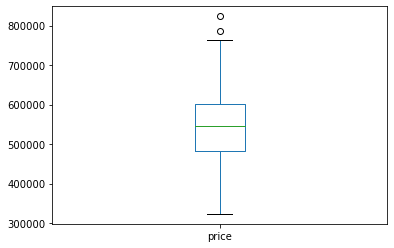

In [42]:
kc_DF_wDUMS.groupby('age').price.mean().plot(kind='box')

Strip date for month sold

In [43]:
kc_DF_wDUMS['month_sold'] = kings_county_df['date'].dt.month
kc_DF_wDUMS['month_sold'].value_counts()


5     1928
4     1804
7     1761
6     1753
8     1561
3     1496
10    1493
9     1388
12    1170
11    1154
2      990
1      792
Name: month_sold, dtype: int64

Strip date for year sold 

In [44]:
kc_DF_wDUMS['year_sold'] = kc_DF_wDUMS['date'].dt.year
kc_DF_wDUMS['year_sold'].value_counts()

2014    11703
2015     5587
Name: year_sold, dtype: int64

In [45]:
kc_DF_wDUMS.drop('date',axis=1, inplace=True)


***month***

H0: Average price was the same across months. <br>
H1: Average price was not the same across months.

In [46]:
#alpha = .05
samples = kc_DF_wDUMS.groupby('month_sold')['price'].apply(list)

stats.f_oneway(*samples)
#Pvalue much lower than alpha, reject null hypothesis

F_onewayResult(statistic=2.7046975005044085, pvalue=0.0017444151469153434)

In [47]:
kc_DF_wDUMS.month_sold.value_counts().sort_index()

1      792
2      990
3     1496
4     1804
5     1928
6     1753
7     1761
8     1561
9     1388
10    1493
11    1154
12    1170
Name: month_sold, dtype: int64

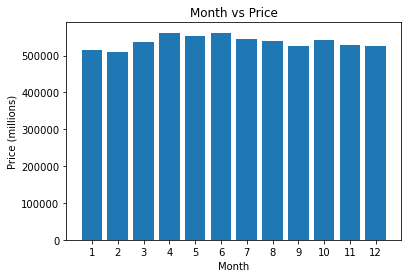

In [48]:
#View average price by month
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('month_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Month vs Price")
ax.set_xlabel("Month")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

***season***

In [49]:
#Create seasons column
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
#{1: Winter, 2: Spring, 3: Summer, 4: Fall}
month_to_season = dict(zip(range(1,13), seasons))
kc_DF_wDUMS['season_sold'] = kc_DF_wDUMS.month_sold.map(month_to_season)
kc_DF_wDUMS['season_sold'].value_counts()


Spring    5228
Summer    5075
Fall      4035
Winter    2952
Name: season_sold, dtype: int64

H0: Average price was the same across seasons <br>
H1: Average price wasn't the same across seasons

In [50]:
#alpha = .05
samples = kc_DF_wDUMS.groupby('season_sold')['price'].apply(list)


fstat, pstat = stats.f_oneway(*samples)
fstat,pstat
#Pvalue lower than alpha, reject null hypothesis

(6.882461546105218, 0.00012530436472821217)

In [51]:
kc_DF_wDUMS.season_sold.value_counts()

Spring    5228
Summer    5075
Fall      4035
Winter    2952
Name: season_sold, dtype: int64

In [52]:
kc_DF_wDUMS.groupby('season_sold')['price'].mean()

season_sold
Fall      532412.593309
Spring    551941.793420
Summer    549242.508768
Winter    517664.144309
Name: price, dtype: float64

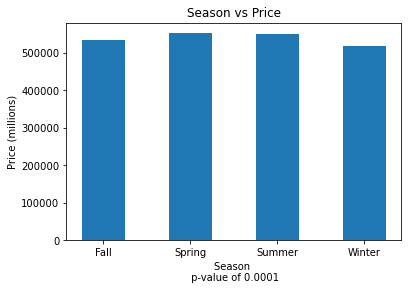

In [53]:
#View average price by season
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('season_sold')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values,
      width= .50)
ax.set_title("Season vs Price")
ax.set_xlabel(f"Season \n p-value of {round(pstat,4)}")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

***year_sold***

H0: Average price was the same across years. <br>
H1: Average price wasn't the same across years

In [54]:
#alpha = .05

samples = kc_DF_wDUMS.groupby('year_sold')['price'].apply(list)
stats.ttest_ind(*samples)
#Pvalue greater than alpha, fail to reject null

Ttest_indResult(statistic=0.3069020541875544, pvalue=0.75892162179952)

In [55]:
kc_DF_wDUMS.year_sold.value_counts()

2014    11703
2015     5587
Name: year_sold, dtype: int64

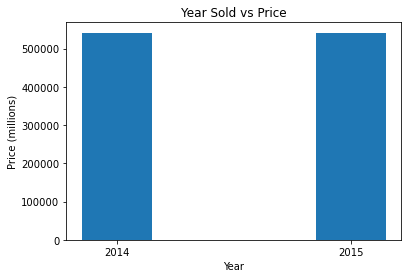

In [56]:
#View year and its average price
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('year_sold')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values,
      width= .30)
ax.set_title("Year Sold vs Price")
ax.set_xlabel("Year")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

***grade***

H0: Average price is the same with regards to grade <br>
H1: Average price isn't the same

In [57]:
#alpha = .05
samples = kings_county_df.groupby('grade')['price'].apply(list)

stats.f_oneway(*samples)
#pvalue less than alpha, reject null

F_onewayResult(statistic=1763.5110290471393, pvalue=0.0)

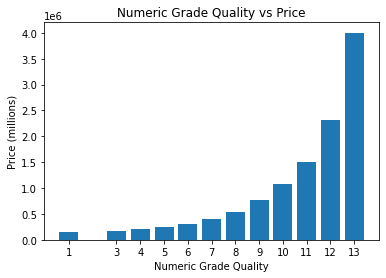

In [58]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('grade')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Numeric Grade Quality vs Price")
ax.set_xlabel("Numeric Grade Quality")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

In [59]:
#alpha =.05
#H0: Average price is the same with regards grouped grades
#H1: Average price isn't the same with regards to grouped grades

samples = kings_county_df.groupby('grade_cat')['price'].apply(list)

fstat, pval = stats.f_oneway(*samples)
fstat, pval

#reject null, pvalue less than alpha

(4810.289855501282, 0.0)

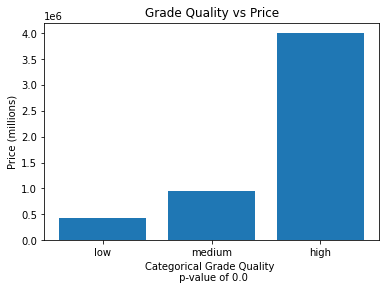

In [60]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('grade_cat')['price'].mean().sort_values()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Grade Quality vs Price")
ax.set_xlabel(f"Categorical Grade Quality \n p-value of {pval}")
ax.set_ylabel("Price (millions)");

***views***

H0: Average price is the same whether or not the house has a view <br>
H1: Average price isn't the same whether or not the house has a view

In [61]:
#alpha = .05

stats.ttest_ind(kings_county_df.query("view==True")['price'],kings_county_df.query("view == False")['price'])
#reject null, pvalue less than alpha

Ttest_indResult(statistic=17.335586885770702, pvalue=1.0461414698919182e-66)

In [62]:
kings_county_df.view.unique()

array([0, 2, 3, 4, 1])

H0: Amount of views have the same average price <br>
H1: Amount of views do not have the same average price.

In [63]:
samples = kings_county_df.groupby('view')['price'].apply(list)
stats.f_oneway(*samples)
#pvalue less than alpha, reject null

F_onewayResult(statistic=876.7689357683041, pvalue=0.0)

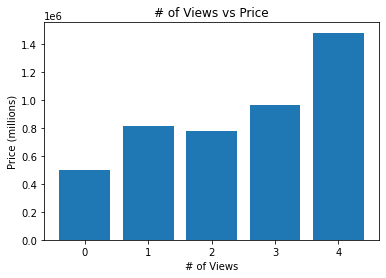

In [64]:
fig, ax = plt.subplots()
grouped = kings_county_df.groupby('view')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("# of Views vs Price")
ax.set_xlabel("# of Views")
ax.set_ylabel("Price (millions)");

***is_renovated***

In [65]:
kc_DF_wDUMS['is_renovated'] = np.where(kc_DF_wDUMS['yr_renovated'] > 0, 1, 0)
kc_DF_wDUMS.drop('yr_renovated',axis=1, inplace=True)
kc_DF_wDUMS['is_renovated'].value_counts()


0    16564
1      726
Name: is_renovated, dtype: int64

H0: Average price is the same whether a house is or isn't renovated <br>
H1: Average price is not the same whether a house is or isn't renovated


In [66]:
#alpha = .05
stats.ttest_ind(kc_DF_wDUMS.query("is_renovated == True")['price'], kc_DF_wDUMS.query("is_renovated == False")['price'])
#P value less than alpha, reject null

Ttest_indResult(statistic=15.544856792041145, pvalue=4.007705820364685e-54)

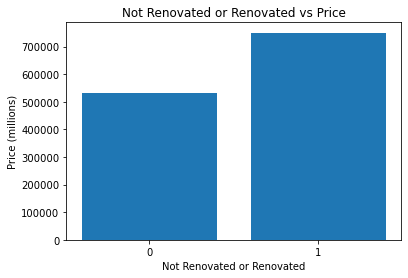

In [67]:
fig, ax = plt.subplots()
grouped = kc_DF_wDUMS.groupby('is_renovated')['price'].mean()
ax.bar(x=grouped.index,
        height = grouped.values)
ax.set_title("Not Renovated or Renovated vs Price")
ax.set_xlabel("Not Renovated or Renovated")
ax.set_ylabel("Price (millions)")
ax.set_xticks(grouped.index);

#### Linear Regression

Create dummies for season_sold as well

In [68]:
kc_DF_wDUMS = pd.get_dummies(kc_DF_wDUMS, columns = ['season_sold'], drop_first=True)


In [69]:
kc_DF_wDUMS.describe()

,price,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,grade_cat_medium,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_7.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,age,month_sold,year_sold,is_renovated,season_sold_Spring,season_sold_Summer,season_sold_Winter
count,1.729000e+04,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.00000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,2081.464604,1.524340e+04,0.007981,0.238519,7.654425,1789.306015,292.158589,1987.986698,12873.475824,1.013187,0.008039,0.650318,0.261191,0.079063,0.803702,0.195662,0.009254,0.127473,0.454887,0.317409,0.074205,0.013245,0.002834,0.182475,0.000347,0.067553,0.140602,0.089589,0.096356,0.249971,0.051822,0.034239,0.026316,0.034182,0.007808,0.006189,0.003702,0.004396,0.000925,0.000983,0.000636,0.000405,0.001041,0.088143,0.378138,0.008097,0.027473,0.000405,0.00908,0.012955,0.013707,0.008097,0.022267,0.007056,0.013071,0.004280,0.009427,0.005842,0.008386,0.010931,0.023713,0.003759,0.019202,0.012666,0.014459,0.011625,0.012435,0.005957,0.020532,0.025159,0.026316,0.002429,0.013245,0

In [70]:
import statsmodels.api as sm

In [71]:
#Create simple first model

In [72]:
X = sm.add_constant(kc_DF_wDUMS[['age','is_renovated','month_sold','season_sold_Spring','season_sold_Summer','season_sold_Winter']])
y = kc_DF_wDUMS['price']
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     65.08
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           2.59e-80
Time:                        06:08:07   Log-Likelihood:            -2.4617e+05
No. Observations:               17290   AIC:                         4.924e+05
Df Residuals:                   17283   BIC:                         4.924e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5.669e+05   1.46e+04     38.847      0.000    5.38e+05    5.96e+05
age                -1105.8678     98.177    -11.264      0.000   -1298.304    -913.432
is_renovated        2.538e+05   1.44e+04     17.668      0.000    2.26e+05    2.82e+05
month_sold           982.4903   1253.941      0.784      0.433   -1475.361    3440.342
season_sold_Spring  2.579e+04   1.07e+04      2.417      0.016    4872.098    4.67e+04
season_sold_Summer  1.981e+04   8638.329      2.293      0.022    2879.299    3.67e+04
season_sold_Winter -8200.5723   1.04e+04     -0.788      0.431   -2.86e+04    1.22e+04
==============================================================================
Omnibus:                    15920.305   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1089783.434
Skew:                           4.241   Prob(JB):                         0.00
Kurtosis:                      40.957   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
#Create an interaction between winter and sqft_living..
#No Idea, just wanted to see it 
kc_DF_wDUMS['winterXsqft_living'] = kc_DF_wDUMS['season_sold_Winter']*kc_DF_wDUMS['sqft_living']

In [74]:
#Create an interaction between spring and sqft_living..
#No Idea, just wanted to see it 
kc_DF_wDUMS['springXsqft_living'] = kc_DF_wDUMS['season_sold_Spring']*kc_DF_wDUMS['sqft_living']


In [75]:
#Create an itneraction between age and num times sold
#Idea was, maybe it could represent wear and tear??
kc_DF_wDUMS['ageXnumTimesSold'] = kc_DF_wDUMS['age']*kc_DF_wDUMS['num_times_sold']

Initial model with only `zipcode` dummies

In [76]:
subset =[*all_zips]

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     167.4
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        06:08:07   Log-Likelihood:            -2.4193e+05
No. Observations:               17290   AIC:                         4.840e+05
Df Residuals:                   17220   BIC:                         4.845e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.82e+05   1.72e+04     16.421      0.000    2.48e+05    3.16e+05
zipcode_98002 -4.971e+04   2.88e+04     -1.727      0.084   -1.06e+05    6701.740
zipcode_98003  8763.9215   2.59e+04      0.339      0.735   -4.19e+04    5.95e+04
zipcode_98004  1.115e+06   2.55e+04     43.787      0.000    1.06e+06    1.16e+06
zipcode_98005  5.268e+05   2.99e+04     17.629      0.000    4.68e+05    5.85e+05
zipcode_98006  5.675e+05   2.26e+04     25.068      0.000    5.23e+05    6.12e+05
zipcode_98007  3.156e+05   3.13e+04     10.073      0.000    2.54e+05    3.77e+05
zipcode_98008  3.588e+05   2.58e+04     13.907      0.000    3.08e+05    4.09e+05
zipcode_98010  1.429e+05   3.78e+04      3.783      0.000    6.88e+04    2.17e+05
zipcode_98011  2.086e+05   2.84e+04      7.337      0.000    1.53e+05    2.64e+05
zipcode_98014  1.742e+05   3.35e+04      5.196      0.000    1.08e+05     2.4e+05
zipcode_98019  1.464e+05   2.95e+04      4.957      0.000    8.85e+04    2.04e+05
zipcode_98022  2.677e+04   2.72e+04      0.985      0.324   -2.65e+04       8e+04
zipcode_98023  7573.8820   2.23e+04      0.339      0.735   -3.62e+04    5.14e+04
zipcode_98024   3.09e+05   3.98e+04      7.765      0.000    2.31e+05    3.87e+05
zipcode_98027  3.253e+05   2.34e+04     13.907      0.000    2.79e+05    3.71e+05
zipcode_98028  1.864e+05    2.6e+04      7.163      0.000    1.35e+05    2.37e+05
zipcode_98029  3.337e+05   2.51e+04     13.295      0.000    2.84e+05    3.83e+05
zipcode_98030   1.44e+04   2.67e+04      0.540      0.589   -3.79e+04    6.67e+04
zipcode_98031   1.86e+04   2.62e+04      0.711      0.477   -3.27e+04    6.99e+04
zipcode_98032  -3.04e+04   3.33e+04     -0.913      0.361   -9.56e+04    3.48e+04
zipcode_98033  5.207e+05    2.3e+04     22.601      0.000    4.76e+05    5.66e+05
zipcode_98034  2.419e+05   2.21e+04     10.955      0.000    1.99e+05    2.85e+05
zipcode_98038  8.642e+04   2.19e+04      3.949      0.000    4.35e+04    1.29e+05
zipcode_98039  1.921e+06   4.78e+04     40.147      0.000    1.83e+06    2.01e+06
zipcode_98040   9.01e+05   2.57e+04     35.055      0.000    8.51e+05    9.51e+05
zipcode_98042  2.717e+04   2.22e+04      1.224      0.221   -1.63e+04    7.07e+04
zipcode_98045  1.493e+05   2.78e+04      5.378      0.000    9.49e+04    2.04e+05
zipcode_98052  3.641e+05   2.17e+04     16.764      0.000    3.21e+05    4.07e+05
zipcode_98053  3.953e+05   2.35e+04     16.805      0.000    3.49e+05    4.41e+05
zipcode_98055  2.485e+04   2.63e+04      0.944      0.345   -2.68e+04    7.65e+04
zipcode_98056  1.415e+05   2.33e+04      6.066      0.000    9.58e+04    1.87e+05
zipcode_98058  7.237e+04   2.26e+04      3.197      0.001     2.8e+04    1.17e+05
zipcode_98059  2.124e+05   2.28e+04      9.318      0.000    1.68e+05    2.57e+05
zipcode_98065  2.452e+05   2.51e+04      9.760   

Initial model with two dummied variables

In [77]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7']

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
sm.OLS(y,X).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     195.0
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        06:08:08   Log-Likelihood:            -2.4100e+05
No. Observations:               17290   AIC:                         4.821e+05
Df Residuals:                   17213   BIC:                         4.827e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           2.04e+05   8.11e+04      2.516      0.012    4.51e+04    3.63e+05
zipcode_98002 -3.834e+04   2.73e+04     -1.405      0.160   -9.18e+04    1.51e+04
zipcode_98003  1.273e+04   2.45e+04      0.519      0.604   -3.53e+04    6.08e+04
zipcode_98004  1.066e+06   2.42e+04     44.112      0.000    1.02e+06    1.11e+06
zipcode_98005   4.78e+05   2.83e+04     16.864      0.000    4.22e+05    5.34e+05
zipcode_98006  5.212e+05   2.15e+04     24.264      0.000    4.79e+05    5.63e+05
zipcode_98007  2.785e+05   2.97e+04      9.374      0.000     2.2e+05    3.37e+05
zipcode_98008  3.206e+05   2.45e+04     13.104      0.000    2.73e+05    3.69e+05
zipcode_98010  1.476e+05   3.58e+04      4.124      0.000    7.75e+04    2.18e+05
zipcode_98011  1.889e+05    2.7e+04      7.008      0.000    1.36e+05    2.42e+05
zipcode_98014  2.125e+05   3.18e+04      6.681      0.000     1.5e+05    2.75e+05
zipcode_98019  1.452e+05    2.8e+04      5.187      0.000    9.03e+04       2e+05
zipcode_98022  5.656e+04   2.58e+04      2.196      0.028    6075.732    1.07e+05
zipcode_98023  6998.1903   2.12e+04      0.330      0.741   -3.45e+04    4.85e+04
zipcode_98024  3.107e+05   3.77e+04      8.234      0.000    2.37e+05    3.85e+05
zipcode_98027  3.102e+05   2.22e+04     13.987      0.000    2.67e+05    3.54e+05
zipcode_98028  1.764e+05   2.47e+04      7.151      0.000    1.28e+05    2.25e+05
zipcode_98029  3.287e+05   2.38e+04     13.819      0.000    2.82e+05    3.75e+05
zipcode_98030  2565.4437   2.53e+04      0.101      0.919    -4.7e+04    5.21e+04
zipcode_98031  5460.1798   2.48e+04      0.220      0.826   -4.31e+04    5.41e+04
zipcode_98032 -2.335e+04   3.15e+04     -0.740      0.459   -8.52e+04    3.85e+04
zipcode_98033  4.986e+05   2.18e+04     22.831      0.000    4.56e+05    5.41e+05
zipcode_98034  2.345e+05   2.09e+04     11.204      0.000    1.93e+05    2.75e+05
zipcode_98038  7.944e+04   2.07e+04      3.830      0.000    3.88e+04     1.2e+05
zipcode_98039  1.844e+06   4.54e+04     40.632      0.000    1.76e+06    1.93e+06
zipcode_98040  8.307e+05   2.44e+04     34.008      0.000    7.83e+05    8.79e+05
zipcode_98042  2.835e+04    2.1e+04      1.348      0.178   -1.29e+04    6.96e+04
zipcode_98045  1.723e+05   2.63e+04      6.548      0.000    1.21e+05    2.24e+05
zipcode_98052  3.368e+05   2.06e+04     16.359      0.000    2.96e+05    3.77e+05
zipcode_98053    4.1e+05   2.23e+04     18.367      0.000    3.66e+05    4.54e+05
zipcode_98055   3.92e+04    2.5e+04      1.570      0.116   -9744.929    8.82e+04
zipcode_98056  1.376e+05   2.21e+04      6.221      0.000    9.42e+04    1.81e+05
zipcode_98058  5.771e+04   2.15e+04      2.690      0.007    1.57e+04    9.98e+04
zipcode_98059  1.763e+05   2.16e+04      8.159      0.000    1.34e+05    2.19e+05
zipcode_98065    2.3e+05   2.38e+04      9.655   

Model with features that seemed the most significant

In [78]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view', 'grade_cat_low','grade_cat_medium']

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     499.5
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        06:08:08   Log-Likelihood:            -2.3576e+05
No. Observations:               17290   AIC:                         4.717e+05
Df Residuals:                   17206   BIC:                         4.723e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                3.05e+06   8.63e+04     35.344      0.000    2.88e+06    3.22e+06
zipcode_98002      -2010.7942   2.02e+04     -0.100      0.921   -4.15e+04    3.75e+04
zipcode_98003       1.369e+04   1.81e+04      0.756      0.450   -2.18e+04    4.92e+04
zipcode_98004        9.18e+05   1.79e+04     51.170      0.000    8.83e+05    9.53e+05
zipcode_98005       3.928e+05    2.1e+04     18.714      0.000    3.52e+05    4.34e+05
zipcode_98006       3.507e+05    1.6e+04     21.963      0.000    3.19e+05    3.82e+05
zipcode_98007       2.519e+05    2.2e+04     11.467      0.000    2.09e+05    2.95e+05
zipcode_98008       2.611e+05   1.81e+04     14.429      0.000    2.26e+05    2.97e+05
zipcode_98010       1.052e+05   2.65e+04      3.975      0.000    5.33e+04    1.57e+05
zipcode_98011       1.629e+05   1.99e+04      8.173      0.000    1.24e+05    2.02e+05
zipcode_98014       1.592e+05   2.35e+04      6.769      0.000    1.13e+05    2.05e+05
zipcode_98019       1.511e+05   2.07e+04      7.300      0.000     1.1e+05    1.92e+05
zipcode_98022       7862.4972   1.91e+04      0.412      0.680   -2.95e+04    4.53e+04
zipcode_98023      -9900.0042   1.57e+04     -0.632      0.527   -4.06e+04    2.08e+04
zipcode_98024       2.368e+05   2.79e+04      8.488      0.000    1.82e+05    2.91e+05
zipcode_98027       2.467e+05   1.64e+04     15.034      0.000    2.15e+05    2.79e+05
zipcode_98028       1.599e+05   1.82e+04      8.774      0.000    1.24e+05    1.96e+05
zipcode_98029       2.406e+05   1.76e+04     13.650      0.000    2.06e+05    2.75e+05
zipcode_98030       8465.7459   1.87e+04      0.453      0.650   -2.82e+04    4.51e+04
zipcode_98031       3.131e+04   1.83e+04      1.708      0.088   -4618.080    6.72e+04
zipcode_98032       1887.7650   2.33e+04      0.081      0.935   -4.38e+04    4.76e+04
zipcode_98033        3.94e+05   1.62e+04     24.359      0.000    3.62e+05    4.26e+05
zipcode_98034       2.085e+05   1.55e+04     13.480      0.000    1.78e+05    2.39e+05
zipcode_98038       6.788e+04   1.53e+04      4.427      0.000    3.78e+04    9.79e+04
zipcode_98039       1.504e+06   3.38e+04     44.567      0.000    1.44e+06    1.57e+06
zipcode_98040       6.035e+05   1.82e+04     33.190      0.000    5.68e+05    6.39e+05
zipcode_98042       3.066e+04   1.56e+04      1.972      0.049     179.336    6.11e+04
zipcode_98045        1.21e+05   1.95e+04      6.218      0.000    8.29e+04    1.59e+05
zipcode_98052       2.748e+05   1.53e+04     18.020      0.000    2.45e+05    3.05e+05
zipcode_98053       3.289e+05   1.65e+04     19.880      0.000    2.96e+05    3.61e+05
zipcode_98055         4.7e+04   1.85e+04      2.547      0.011    1.08e+04    8.32e+04
zipcode_98056       1.061e+05   1.63e+04      6.491      0.000    7.41e+04    1.38e+05
zipcode_98058       6.191e+04   1.59e+

Add sqft_living to the model

In [79]:
subset =[*all_zips,'bedrooms_1','bedrooms_2','bedrooms_3','bedrooms_4','bedrooms_5',
        'bedrooms_6','bedrooms_7','season_sold_Spring',
         'season_sold_Summer', 'season_sold_Winter', 'waterfront',
        'view', 'grade_cat_low','grade_cat_medium','sqft_living']

X = sm.add_constant(kc_DF_wDUMS[subset])
y = kc_DF_wDUMS['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     841.6
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        06:08:09   Log-Likelihood:            -2.3227e+05
No. Observations:               17290   AIC:                         4.647e+05
Df Residuals:                   17205   BIC:                         4.654e+05
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                1.73e+06   7.19e+04     24.057      0.000    1.59e+06    1.87e+06
zipcode_98002       2.507e+04   1.65e+04      1.521      0.128   -7239.032    5.74e+04
zipcode_98003         26.4608   1.48e+04      0.002      0.999    -2.9e+04     2.9e+04
zipcode_98004        8.32e+05   1.47e+04     56.653      0.000    8.03e+05    8.61e+05
zipcode_98005       3.384e+05   1.72e+04     19.722      0.000    3.05e+05    3.72e+05
zipcode_98006       2.916e+05   1.31e+04     22.324      0.000    2.66e+05    3.17e+05
zipcode_98007       2.753e+05   1.79e+04     15.335      0.000     2.4e+05     3.1e+05
zipcode_98008       2.724e+05   1.48e+04     18.423      0.000    2.43e+05    3.01e+05
zipcode_98010       7.268e+04   2.16e+04      3.362      0.001    3.03e+04    1.15e+05
zipcode_98011       1.329e+05   1.63e+04      8.159      0.000    1.01e+05    1.65e+05
zipcode_98014       1.058e+05   1.92e+04      5.504      0.000    6.81e+04    1.43e+05
zipcode_98019         8.5e+04   1.69e+04      5.024      0.000    5.18e+04    1.18e+05
zipcode_98022       1.444e+04   1.56e+04      0.926      0.354   -1.61e+04     4.5e+04
zipcode_98023      -2.172e+04   1.28e+04     -1.698      0.089   -4.68e+04    3350.174
zipcode_98024       1.811e+05   2.28e+04      7.941      0.000    1.36e+05    2.26e+05
zipcode_98027       1.795e+05   1.34e+04     13.370      0.000    1.53e+05    2.06e+05
zipcode_98028        1.28e+05   1.49e+04      8.592      0.000    9.88e+04    1.57e+05
zipcode_98029       2.191e+05   1.44e+04     15.209      0.000    1.91e+05    2.47e+05
zipcode_98030       4708.7800   1.53e+04      0.308      0.758   -2.52e+04    3.46e+04
zipcode_98031       2.163e+04    1.5e+04      1.444      0.149   -7725.369     5.1e+04
zipcode_98032       2.114e+04   1.91e+04      1.109      0.267   -1.62e+04    5.85e+04
zipcode_98033       3.708e+05   1.32e+04     28.059      0.000    3.45e+05    3.97e+05
zipcode_98034       2.124e+05   1.26e+04     16.806      0.000    1.88e+05    2.37e+05
zipcode_98038       3.059e+04   1.25e+04      2.440      0.015    6019.566    5.52e+04
zipcode_98039       1.332e+06   2.76e+04     48.201      0.000    1.28e+06    1.39e+06
zipcode_98040       5.443e+05   1.49e+04     36.608      0.000    5.15e+05    5.73e+05
zipcode_98042       1.739e+04   1.27e+04      1.369      0.171   -7514.619    4.23e+04
zipcode_98045       1.013e+05   1.59e+04      6.368      0.000    7.01e+04    1.32e+05
zipcode_98052        2.45e+05   1.25e+04     19.661      0.000    2.21e+05    2.69e+05
zipcode_98053       2.133e+05   1.36e+04     15.714      0.000    1.87e+05     2.4e+05
zipcode_98055       4.695e+04   1.51e+04      3.114      0.002    1.74e+04    7.65e+04
zipcode_98056       9.791e+04   1.34e+04      7.333      0.000    7.17e+04    1.24e+05
zipcode_98058       4.795e+04    1.3e+

High R2 meaning that 80% of the model can be explained by the dependent variables

### Holdout Predictions

###### First Simple Model

In [80]:
# df_features = kc_DF_ME.drop('price', axis=1)
# target = kc_DF_ME['price']
df_features = kc_DF_wDUMS.drop('price', axis=1)
target = kc_DF_wDUMS['price']

**Create Train/Test Split**

In [81]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_features, 
                                                        target,
                                                        random_state = 1,
                                                        test_size = .2)

In [82]:
import numpy as np
np.sqrt(X_train1.count())[0]

117.60952342391326

In [83]:
X_train1.columns.size

127

**Predict Training Set**

In [84]:
lr1 = LinearRegression()
lr1.fit(X_train1, y_train1)

LinearRegression()

In [85]:
y_train_predict1 = lr1.predict(X_train1)


In [86]:
train_rmse1 = np.sqrt(metrics.mean_squared_error(y_train1, y_train_predict1))

In [87]:
print('Root Mean Squared Error:', train_rmse1)

Root Mean Squared Error: 155782.82757300587


<b>Predicting Test Set</b>

In [88]:
y_test_pred1 = lr1.predict(X_test1)

In [89]:
test_rmse1 = np.sqrt(metrics.mean_squared_error(y_test1, y_test_pred1))
print('Root Mean Squared Error:' + str(test_rmse1))

Root Mean Squared Error:147238.48945950076


**Comparing Test vs Training data**

In [90]:
print('Training: ', int(train_rmse1), "vs. Testing: ", int(test_rmse1))

Training:  155782 vs. Testing:  147238


**Check to see if errors are normally distributed**

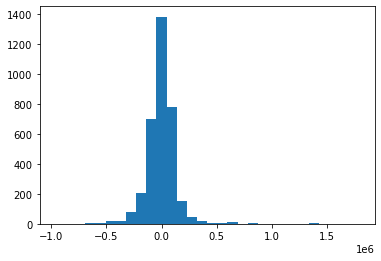

In [91]:
residuals1 = (y_test1 - y_test_pred1)
plt.hist(residuals1, bins=30);

Somewhat right skewed

<AxesSubplot:xlabel='price', ylabel='price'>

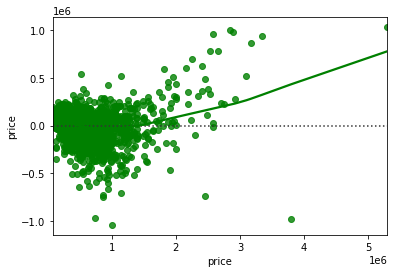

In [92]:
sns.residplot(y_test1, residuals1, lowess=True, color='g')

Errors are heteroskedastic and not independent and identically distributed!!

**Use the log of price**

In [93]:
lr_log1 = LinearRegression()
lr_log1.fit(X_train1, np.log(y_train1))

LinearRegression()

**Predict Training Set Using Log of Price**

In [94]:
y_log_train_pred1 = lr_log1.predict(X_train1)

In [95]:
y_log_train_pred1 = np.exp(y_log_train_pred1)

In [96]:
log_train_rmse1 = np.sqrt(metrics.mean_squared_error(y_train1, y_log_train_pred1))

print('Root Mean Squared Error [LOG Training]:' , log_train_rmse1)

Root Mean Squared Error [LOG Training]: 140794.0022884096


**Predicting Test Set Using Log of Price**

In [97]:
y_log_test_pred1 = lr_log1.predict(X_test1)
y_log_test_pred1 = np.exp(y_log_test_pred1)

In [98]:
log_test_rmse1 = np.sqrt(metrics.mean_squared_error(y_test1, y_log_test_pred1))

In [99]:
print('Root Mean Squared Error [LOG Testing]:' , log_test_rmse1)

Root Mean Squared Error [LOG Testing]: 120569.23426098685


**Comparing Test vs Log Test data**

In [100]:
print('Original: ', int(test_rmse1), "vs. Logged: ", int(log_test_rmse1))

Original:  147238 vs. Logged:  120569


**Check to see if errors are normally distributed Using Log of Price**

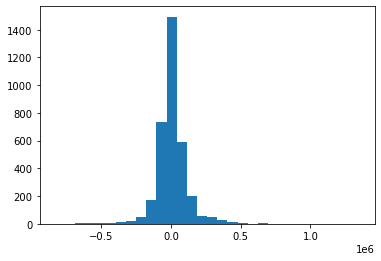

In [101]:
residuals = y_test1 - y_log_test_pred1
plt.hist(residuals, bins=30);

Normally Distributed Errors...somewhat??

<AxesSubplot:xlabel='price', ylabel='price'>

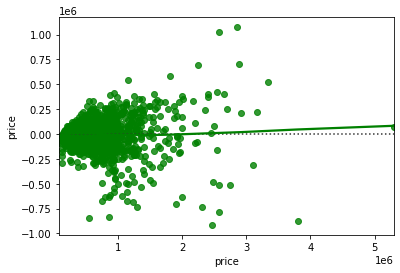

In [102]:
sns.residplot(y_test1, residuals, lowess=True, color='g')

Errors looking homoskedastic and IID

#### Feature Selection

**F Test**

In [103]:
np.sqrt(17280)

131.45341380123986

In [104]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_features, 
                                                        target,
                                                        random_state = 1,
                                                        test_size = .2)

In [105]:
np.sqrt(X_train2.shape[0])

117.60952342391326

Select the top 65 features from all features

In [106]:
selector = SelectKBest(f_regression, k=65)
selector.fit(X_train2, y_train2)
selected_columns_Kbest = X_train2.columns[selector.get_support()]
removed_column_Kbest = X_train2.columns[~selector.get_support()]

In [107]:
lm_kbest = LinearRegression()
lm_kbest.fit(X_train2[selected_columns_Kbest], y_train2)
y_train_kbest = lm_kbest.predict(X_train2[selected_columns_Kbest])
trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train2, y_train_kbest))
print('Training Root Mean Squared Error:' , trainK_rmse)
y_kbest = lm_kbest.predict(X_test2[selected_columns_Kbest])
testK_rmse = np.sqrt(metrics.mean_squared_error(y_test2, y_kbest))
print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 173145.67607959392
Testing Root Mean Squared Error: 160561.33872449238


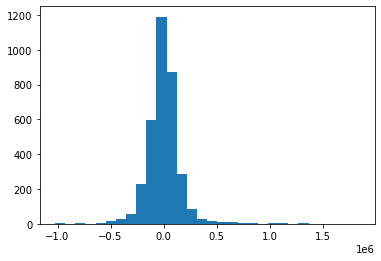

In [108]:
residuals2 = y_test2 - y_kbest
plt.hist(residuals2, bins=30);

Kind of normally distributed?

<AxesSubplot:xlabel='price', ylabel='price'>

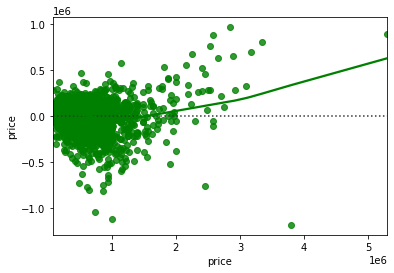

In [109]:
sns.residplot(y_test2, residuals2, lowess=True, color ='g')

Heteroskedastic and not IID

Use log of price in K-best

In [110]:
lm_log_kbest = LinearRegression()
lm_log_kbest.fit(X_train2[selected_columns_Kbest], np.log(y_train2))
y_log_k_train_pred = lm_log_kbest.predict(X_train2[selected_columns_Kbest])
y_log_k_train_pred = np.exp(y_log_k_train_pred)
train_log_k_rmse = np.sqrt(metrics.mean_squared_error(y_train2, y_log_k_train_pred))
print('Training Root Mean Squared Error [LOG]:' , train_log_k_rmse)

y_log_k_test = lm_log_kbest.predict(X_test2[selected_columns_Kbest])
y_log_k_test = np.exp(y_log_k_test)
test_log_k_rmse = np.sqrt(metrics.mean_squared_error(y_test2, y_log_k_test))
print('Testing Root Mean Squared Error [LOG]:' , test_log_k_rmse)


Training Root Mean Squared Error [LOG]: 160638.69058816496
Testing Root Mean Squared Error [LOG]: 143259.27394654206


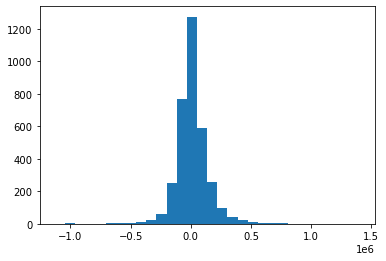

In [111]:
residualslog2 = y_test2 - y_log_k_test
plt.hist(residualslog2, bins=30);

Errors look normally distributed

<AxesSubplot:xlabel='price', ylabel='price'>

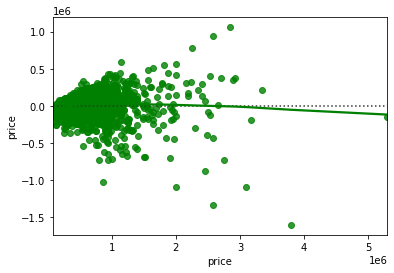

In [112]:
sns.residplot(y_test2, residualslog2, lowess=True, color="g")

Errors look homoskedastic, independent and identical distributed

In [113]:
lm_log_kbest.coef_

array([ 9.83651659e-05,  3.66956911e-07,  4.03551603e-01,  5.47913686e-02,
        1.47279870e-01,  5.63260698e-05,  4.20390972e-05,  5.83812281e-05,
       -4.20598109e-07,  8.46499790e-02,  6.31026005e-02,  5.26444029e-02,
        2.86586111e-02,  3.05559867e-02,  1.02504536e-02, -2.29697122e-02,
       -1.45340031e-01, -9.34526218e-02, -4.66707003e-02, -3.38421273e-02,
        2.38035388e-02,  3.84584391e-02,  6.33651565e-02,  5.02646832e-02,
        6.89829987e-02,  3.51061545e-02,  5.33847698e-02,  3.37088969e-02,
        1.78457264e-02,  9.94485450e-02,  1.38840245e-02,  3.40825926e-02,
       -2.30380193e-01, -3.32967325e-03,  2.92207592e-02, -4.93858102e-01,
       -4.96041156e-01,  5.76310950e-01,  2.11947310e-01,  1.06775599e-01,
       -5.14107371e-01, -4.30317235e-01, -3.94025593e-01,  2.71762499e-01,
       -2.84615246e-01,  7.37907870e-01,  3.28265392e-01, -3.93122359e-01,
       -3.60614480e-01, -3.12592014e-01,  5.55042243e-02, -4.30348373e-01,
        3.17508989e-01,  

Remove highest correlated features first before doing polynomial features

In [114]:
X_train_before, X_test_before, y_train_before, y_test_before = train_test_split(df_features,                                                                               target,                                                                                random_state = 1,
                                                                                test_size = .2)
corr_matrix = X_train_before.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop

df_features.drop(to_drop, axis=1,inplace=True)

**With 2 Polynomial Features + RFECV**

In [115]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns = poly2_columns)
df_poly2.head()

,sqft_living,sqft_lot,waterfront,view,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,num_times_sold,condition_2,condition_3,condition_4,condition_5,grade_cat_low,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_7.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,age,month_sold,year_sold,is_renovated,season_sold_Spring,season_sold_Summer,season_sold_Winter,winterXsqft_living,springXsqft_living,sqft_living^2,sqft_living sqft_lot,sqft_living waterfront,sqft_living view,sqft_living grade,sqft_living sqft_above,sqft_living sqft_basement,sqft_living sqft_living15,sqft_living sqft_lot15,sqft_living num_times_sold,sqft_living condition_2,sqft_living condition_3,sqft_living condition_4,sqft_living condition_5,sqft_living grade_cat_low,sqft_living bedrooms_1,sqft_living bedrooms_2,sqft_living bedrooms_3,sqft_living bedrooms_4,sqft_living bedrooms_5,sqft_living bedrooms_6,sqft_living bedrooms_7,sqft_living bathrooms_1.0,sqft_living bathrooms_1.25,sqft_living bathrooms_1.5,...,zipcode_98155 zipcode_98177,zipcode_98155 zipcode_98178,zipcode_98155 zipcode_98188,zipcode_98155 zipcode_98198,zipcode_98155 zipcode_98199,zipcode_98155 age,zipcode_98155 month_sold,zipcode_98155 year_sold,zipcode_98155 is_renovated,zipcode_98155 season_sold_Spring,zipcode_98155 season_sold_Summer,zipcode_98155 season_sold_Winter,zipcode_98155 winterXsqft_living,zipcode_98155 springXsqft_living,zipcode_98166^2,zipcode_98166 zipcode_98168,zipcode_98166 zipcode_98177,zipcode_98166 zipcode_98178,zipcode_98166 zipcode_98188,zipcode_98166 zipcode_98198,zipcode_98166 zipcode_98199,zipcode_98166 age,zipcode_98166 month_sold,zipcode_98166 year_sold,zipcode_98166 is_renovated,zipcode_98166 season_sold_Spring,zipcode_98166 season_sold_Summer,zipcode_98166 season_sold_Winter,zipcode_98166 winterXsqft_living,zipcode_98166 springXsqft_living,zipcode_98168^2,zipcode_98168 zipcode_98177,zipcode_98168 zipcode_98178,zipcode_98168 zipcode_98188,zipcode_98168 zipcode_98198,zipcode_98168 zipcode_98199,zipcode_98168 age,zipcode_98168 month_sold,zipcode_98168 year_sold,zipcode_98168 is_renovated,zipcode_98168 season_sold_Spring,zipcode_98168 season_sold_Summer,zipcode_98168 season_sold_Winter,zipcode_98168 winterXsqft_living,zipcode_98168 springXsqft_living,zipcode_98177^2,zipcode_98177 zipcode_98178,zipcode_98177 zipcode_98188,zipcode_98177 zipcode_98198,zipcode_98177 zipcode_98199,zipcode_98177 age,zipcode_98177 month_sold,zipcode_98177 year_sold,zipcode_98177 is_renovated,zipcode_98177 season_sold_Spring,zipcode_98177 season_sold_Summer,zipcode_98177 season_sold_Winter,zipcode_98177 winterXsqft_living,zipcode_98177 springXsqft_living,zipcode_98178^2,zipcode_98178 zipcode_98188,zipcode_98178 zipcode_98198,zipcode_9

In [116]:
useless_cols = df_poly2.columns[df_poly2.apply(lambda col: col.sum() ==0)]

useless_cols

df_poly2.drop(useless_cols, axis=1,inplace=True )

In [117]:
df_poly2.shape

(17290, 4582)

In [118]:
np.sqrt(17280)

131.45341380123986

In [119]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_poly2,
                                                    target,
                                                    random_state = 1,
                                                    test_size = .2)

In [120]:
X_train3.shape[0]**.5

117.60952342391326

Chose 116, one less than square root of observations

In [121]:
selector = SelectKBest(f_regression, k=116)
selector.fit(X_train3, y_train3)
selected_columns = X_train3.columns[selector.get_support()]
removed_columns = X_train3.columns[~selector.get_support()]

In [122]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=2, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
selector.fit(X_train3[selected_columns], y_train3)

Fitting estimator with 116 features.


RFECV(cv=7, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [123]:
selected_rfe = X_train3[selected_columns].columns[selector.support_]
removed_rfe = X_train3[selected_columns].columns[~selector.support_]

In [124]:
lm_rfe = LinearRegression()
lm_rfe = lm_rfe.fit(X_train3[selected_rfe],y_train3)
y_train_pred_rfe = lm_rfe.predict(X_train3[selected_rfe])
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train3, y_train_pred_rfe))
print('Training Root Mean Squared Error', trainRFE_rmse)

Training Root Mean Squared Error 173093.07481632408


In [125]:
y_test_pred_rfe = lm_rfe.predict(X_test3[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test3, y_test_pred_rfe))
print('Testing Root Mean Squared Error', testRFE_rmse)

Testing Root Mean Squared Error 177596.2901073332


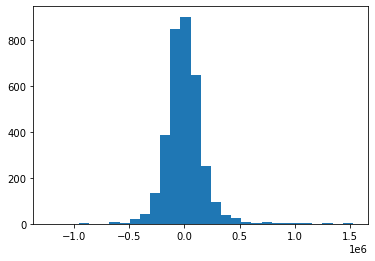

In [126]:
residualsRFE = (y_test3 - y_test_pred_rfe)
plt.hist(residualsRFE, bins=30);

Not normally distributed

<AxesSubplot:xlabel='price', ylabel='price'>

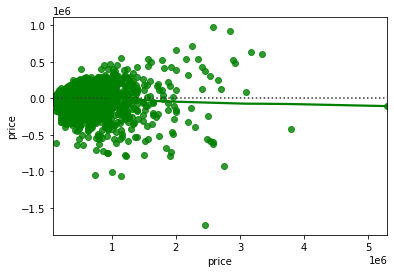

In [127]:
sns.residplot(y_test3, residualsRFE, lowess=True, color = 'g')

Heteroskedastic and not IID

**F Test + RCECV**

In [128]:
np.sqrt(17280)

131.45341380123986

In [129]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(df_features, 
                                                        target,
                                                        random_state = 1,
                                                        test_size = .2)

In [130]:
np.sqrt(X_train4.shape[0])

117.60952342391326

In [131]:
selector = SelectKBest(f_regression, k=117)
selector.fit(X_train4, y_train4)
selected_columns_Kbest_RCEFV = X_train4.columns[selector.get_support()]
removed_column_Kbest_RCEFV = X_train4.columns[~selector.get_support()]

In [132]:
ols = LinearRegression()
selector = RFECV(estimator=ols, step=2, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
selector.fit(X_train4[selected_columns_Kbest_RCEFV], y_train4)


RFECV(cv=7, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [133]:
lm_kbest_rfe = LinearRegression()
lm_kbest_rfe.fit(X_train4[selected_columns_Kbest_RCEFV],y_train4)
y_train_kbest_rfe = lm_kbest_rfe.predict(X_train4[selected_columns_Kbest_RCEFV])
trainK_RFE_rmse = np.sqrt(metrics.mean_squared_error(y_train4, y_train_kbest_rfe))
print('Training Root Mean Squared Error:' , trainK_RFE_rmse)

Training Root Mean Squared Error: 162041.22668100157


In [134]:
y_kbest_rfe = lm_kbest_rfe.predict(X_test4[selected_columns_Kbest_RCEFV])
test_kbest_rfe_rmse = np.sqrt(metrics.mean_squared_error(y_test4 ,y_kbest_rfe))
print('Testing Root Mean Squared Error:' , test_kbest_rfe_rmse)

Testing Root Mean Squared Error: 149430.85998337067


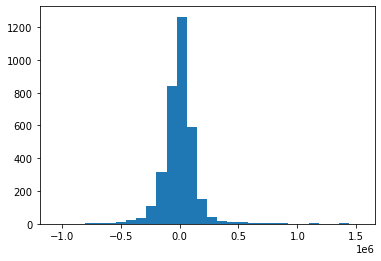

In [135]:
residualsKbestRFE = (y_test4 - y_kbest_rfe)
plt.hist(residualsKbestRFE, bins=30);

Not normally distributed

<AxesSubplot:xlabel='price', ylabel='price'>

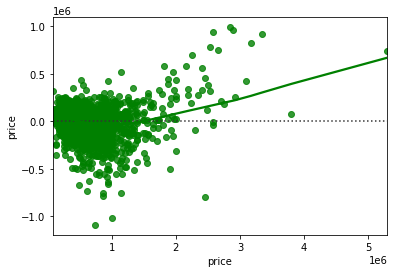

In [136]:
sns.residplot(y_test4, residualsKbestRFE, lowess=True, color = 'g')

Heteroskedastic and not IID

In [137]:
lm_kbest_rfe_log = LinearRegression()
lm_kbest_rfe_log.fit(X_train4[selected_columns_Kbest_RCEFV],np.log(y_train4))
y_log_kbest_rfe_train_pred = lm_kbest_rfe_log.predict(X_train4[selected_columns_Kbest_RCEFV])
y_log_kbest_rfe_train_pred = np.exp(y_log_kbest_rfe_train_pred)
train_log_kbest_rfe_rsme = np.sqrt(metrics.mean_squared_error(y_train4, y_log_kbest_rfe_train_pred))
print('Training Root Mean Squared Error [LOG-kbest_rfe]:' , train_log_kbest_rfe_rsme)

y_log_kbest_rfe_test = lm_kbest_rfe_log.predict(X_test4[selected_columns_Kbest_RCEFV])
y_log_kbest_rfe_test = np.exp(y_log_kbest_rfe_test)
test_log_kbest_rfe_rsme = np.sqrt(metrics.mean_squared_error(y_test4, y_log_kbest_rfe_test))
print('Testing Root Mean Squared Error [LOG-kbest_rfe]:' , test_log_kbest_rfe_rsme)


Training Root Mean Squared Error [LOG-kbest_rfe]: 144681.24443991535
Testing Root Mean Squared Error [LOG-kbest_rfe]: 125351.33828047615


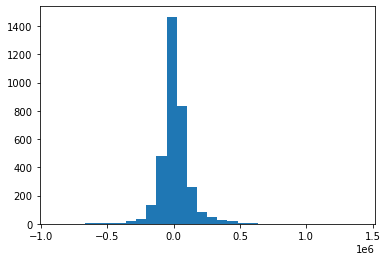

In [138]:
residualsKbestRFElog = (y_test4 - y_log_kbest_rfe_test)
plt.hist(residualsKbestRFElog,bins=30);

Normally distributed

<AxesSubplot:xlabel='price', ylabel='price'>

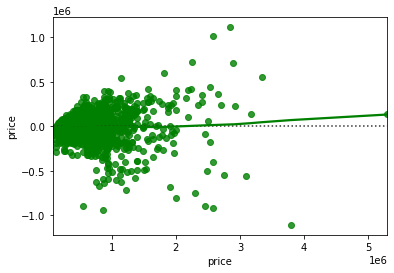

In [139]:
sns.residplot(y_test4, residualsKbestRFElog, lowess=True, color = 'g')

Pretty homoskedastic and IID

**Final Model**

In [140]:
lm_final = LinearRegression()
lm_final = lm_kbest_rfe_log.fit(kc_DF_wDUMS[selected_columns_Kbest_RCEFV], np.log(kc_DF_wDUMS['price']))


In [141]:
lm_final.intercept_

11.425282165459201

In [142]:
len(lm_final.coef_)

117

In [143]:
import pickle

pickle_out = open('pickled_files/model.pickle',"wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [144]:
other_info = [selected_columns_Kbest_RCEFV]
pickle_out = open('pickled_files/other_info.pickle','wb')
pickle.dump(other_info, pickle_out)
pickle_out.close()